In [2]:
!pip install -U albumentations

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import os
import glob
import tensorflow  as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image, ImageEnhance
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

In [5]:

path = r'E:\datasets\dataset_web'
path_imgs = list(glob.glob(path+'/**/*.jpg'))
all_paths=[]
#for label in os.listdir(path):
#    for image in os.listdir(path):
#        all_paths.append(path+label+'/'+image)
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()
#x_train_paths = all_paths[:5000]
#def augment_image(image):
#   image = Image.fromarray(np.uint8(image))
#   image = ImageEnhance.Brightness(image).enhance(random.uniform(0.6,1.4))
#    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.6,1.4))
#   image = np.array(image)/255.0
#    return image
#def open_images(paths):
#    images = []
#   for path in paths:
#       image = load_img(path, target_size=(128,128))
#       image = augment_image(image)
#       images.append(image)
#    return np.array(images)
#train_aug =open_images (file_path) 

,File_Path,Labels
0,E:\datasets\dataset_web\rain\4127282.jpg,rain
1,E:\datasets\dataset_web\hail\0074.jpg,hail
2,E:\datasets\dataset_web\fogsmog\4896.jpg,fogsmog
3,E:\datasets\dataset_web\shine\shine164.jpg,shine
4,E:\datasets\dataset_web\fogsmog\2264492399.jpg,fogsmog


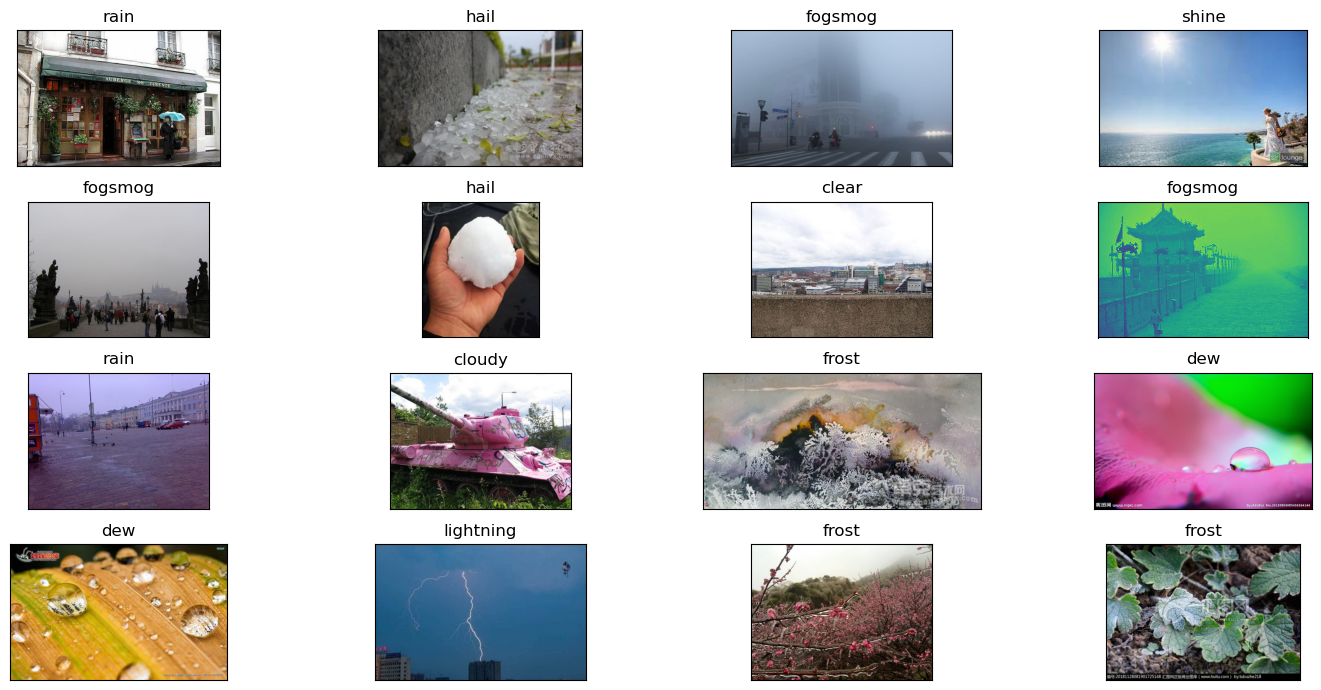

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()


In [7]:

train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)



In [8]:

    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(299,299),
        class_mode='categorical',
        batch_size=32,
        rotation_range=30,
        shuffle=True,
        seed=0,
        subset='training'
        )
    val_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(299,299),
        class_mode='categorical',
        batch_size=32,
        rotation_range=30,
        shuffle=False,
        seed=0,
        subset='validation'
        )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(299,299),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)



Found 8436 validated image filenames belonging to 13 classes.
Found 2108 validated image filenames belonging to 13 classes.
Found 2636 validated image filenames belonging to 13 classes.


In [9]:
test_gen

In [ ]:

base_model =tf.keras.applications.Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=(299,299,3),
    classes=1000,
    classifier_activation="softmax",
)
base_model.trainable = False
adam_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
)
model = Sequential([
    base_model,
    layers.Dense(229, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(114 , activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(11, activation = 'softmax')
])

model.compile(optimizer=adam_optimizer,
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()
history = model.fit(train_gen, 
                    validation_data=val_gen, 
                    epochs=1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                             patience=2)])
results = model.evaluate(val_gen)



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 1000)              22910480  
                                                                 
 dense_24 (Dense)            (None, 229)               229229    
                                                                 
 dropout_16 (Dropout)        (None, 229)               0         
                                                                 
 dense_25 (Dense)            (None, 114)               26220     
                                                                 
 dropout_17 (Dropout)        (None, 114)               0         
                                                                 
 dense_26 (Dense)            (None, 11)                1265      
                                                                 
Total params: 23,167,194
Trainable params: 256,714
Non

In [73]:

pred = model.predict(test_gen )
pred = np.argmax(pred,axis=1)
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
cm=confusion_matrix(val_gen.Labels,pred)
clr = classification_report(val_gen.Labels, pred)
print(clr)

  
    

Found 4406 validated image filenames belonging to 11 classes.
Found 1101 validated image filenames belonging to 11 classes.
80134624/80134624 [==============================] - 1s 0us/step


NameError: ignored

In [ ]:
test_results = {}
    
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.42881
Test Accuracy: 47.97%


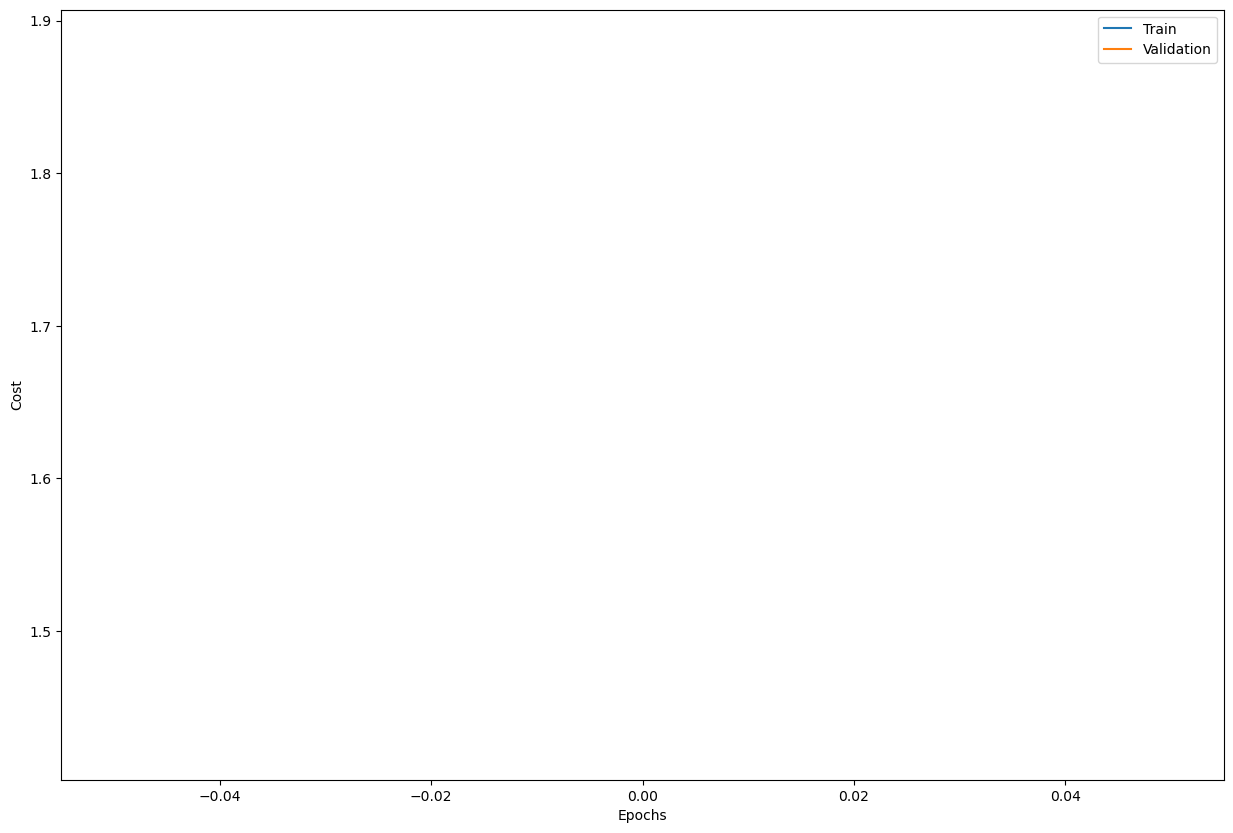

In [ ]:
print_loss(history)

In [ ]:
####model.save(r'C:\machine learning\first\first_ResNet50V2_model')